# Classificação de Sentimentos com BERT

Este notebook implementa um classificador de sentimentos para avaliações de estabelecimentos utilizando **BERT (Bidirectional Encoder Representations from Transformers)**.

## O que é BERT?

BERT é um modelo de linguagem baseado em Transformers desenvolvido pelo Google que revolucionou o NLP:

### Características Principais
- **Bidirecional**: Analisa o contexto à esquerda E à direita simultaneamente
- **Pré-treinado**: Treinado em grandes corpus (Wikipedia, BookCorpus)
- **Transfer Learning**: Fine-tuning para tarefas específicas
- **Contextual Embeddings**: Cada palavra tem representação diferente dependendo do contexto

### Diferenças das Abordagens Anteriores

| Aspecto | BoW | Word2Vec | BERT |
|---------|-----|----------|------|
| Contexto | Nenhum | Janela fixa | Bidirecional completo |
| Embeddings | Esparsos | Estáticos | Contextuais |
| Polissemia | Não trata | Não trata | Captura múltiplos sentidos |
| Pré-treinamento | Não | Sim (Word2Vec) | Sim (massivo) |
| Arquitetura | N/A | Redes rasas | Transformers (12-24 camadas) |

## Objetivo
Usar BERT pré-treinado com fine-tuning para classificar avaliações do Yelp como positivas ou negativas, aproveitando a compreensão profunda de linguagem do modelo.

## 1. Importação de Bibliotecas

Instalando e importando as bibliotecas necessárias para trabalhar com BERT usando Hugging Face Transformers.

In [1]:
# Instalar bibliotecas necessárias (execute apenas uma vez)
! uv run pip install transformers torch datasets accelerate scikit-learn matplotlib seaborn pandas numpy

# NOTA: Se você encontrar erro "cannot import name 'AdamW' from 'transformers'",
# isso é normal nas versões mais recentes. O AdamW foi movido para torch.optim.
# A célula de imports já está corrigida usando: from torch.optim import AdamW


[notice] A new release of pip is available: 25.1.1 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW  # AdamW agora vem do torch.optim
from transformers import (
    BertTokenizer, 
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configurações
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Verificar se GPU está disponível
# Mac usa MPS (Metal Performance Shaders), não CUDA
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"Usando dispositivo: {device} (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Usando dispositivo: {device}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print(f"Usando dispositivo: {device}")
    print("AVISO: GPU não disponível. Treinamento será muito mais lento.")
    
print("Bibliotecas importadas com sucesso!")

Usando dispositivo: mps (Apple Silicon GPU)
Bibliotecas importadas com sucesso!


## 2. Carregamento e Exploração dos Dados

Carregando o dataset do Yelp e preparando para o BERT.

In [5]:
# Carregando o dataset do Yelp
df = pd.read_csv('dataset/yelp_reviews.csv', names=['label', 'text'])

# Converter labels: 1 (negativo) -> 0, 2 (positivo) -> 1 (formato para BERT)
df['label'] = df['label'] - 1

print(f"Dimensões do dataset: {df.shape}")
print(f"\nDistribuição de classes:")
print(df['label'].value_counts())
print(f"\n0 = Negativo, 1 = Positivo")
print(f"\nPrimeiras linhas:")
df.head()

,label,text
0,1,"Contrary to other reviews, I have zero complai..."
1,0,Last summer I had an appointment to get new ti...
2,1,"Friendly staff, same starbucks fair you get an..."
3,0,The food is good. Unfortunately the service is...
4,1,Even when we didn't have a car Filene's Baseme...


In [6]:
# Análise do comprimento dos textos (importante para definir max_length do BERT)
df['text_length'] = df['text'].apply(lambda x: len(x.split()))

print("Estatísticas do Comprimento dos Textos (em palavras):")
print(df['text_length'].describe())

# Visualizar distribuição
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(df['text_length'], bins=50, edgecolor='black', alpha=0.7)
plt.axvline(df['text_length'].quantile(0.95), color='red', linestyle='--', 
            label=f'95º percentil: {df["text_length"].quantile(0.95):.0f}')
plt.axvline(df['text_length'].median(), color='green', linestyle='--', 
            label=f'Mediana: {df["text_length"].median():.0f}')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.title('Distribuição do Comprimento dos Textos')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(df['text_length'])
plt.ylabel('Número de Palavras')
plt.title('Boxplot do Comprimento dos Textos')

plt.tight_layout()
plt.show()

print(f"\n95% dos textos têm até {df['text_length'].quantile(0.95):.0f} palavras")
print(f"Vamos usar max_length=128 tokens para o BERT (cobre a maioria dos casos)")


95% dos textos têm até 367 palavras
Vamos usar max_length=128 tokens para o BERT (cobre a maioria dos casos)


## 3. Configuração do BERT Tokenizer

O tokenizer do BERT converte texto em tokens que o modelo entende. Principais características:
- **WordPiece**: Divide palavras em subpalavras quando necessário
- **Tokens especiais**: [CLS] no início, [SEP] no final
- **Padding**: Completa sequências curtas para ter o mesmo tamanho
- **Truncation**: Corta sequências muito longas

**Nota**: Este notebook usa a API moderna do tokenizer (`tokenizer(...)`) ao invés da API antiga deprecada (`tokenizer.encode_plus(...)`). Ambas funcionam de forma idêntica, mas a API moderna é recomendada.

In [7]:
# Carregar tokenizer pré-treinado do BERT
MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

print(f"Tokenizer carregado: {MODEL_NAME}")
print(f"Tamanho do vocabulário: {tokenizer.vocab_size}")

# Testar tokenização em um exemplo
sample_text = df['text'].iloc[0]
print(f"\nTexto original:\n{sample_text[:200]}...")

# Tokenizar (usando API moderna)
encoded = tokenizer(
    sample_text,
    add_special_tokens=True,
    max_length=128,
    padding='max_length',
    truncation=True,
    return_attention_mask=True,
    return_tensors='pt'
)

print(f"\nTokens (primeiros 20):")
print(tokenizer.convert_ids_to_tokens(encoded['input_ids'][0][:20]))
print(f"\nForma do input_ids: {encoded['input_ids'].shape}")
print(f"Forma do attention_mask: {encoded['attention_mask'].shape}")

Tokenizer carregado: bert-base-uncased
Tamanho do vocabulário: 30522

Texto original:
Contrary to other reviews, I have zero complaints about the service or the prices. I have been getting tire service here for the past 5 years now, and compared to my experience with places like Pep Bo...

Tokens (primeiros 20):
['[CLS]', 'contrary', 'to', 'other', 'reviews', ',', 'i', 'have', 'zero', 'complaints', 'about', 'the', 'service', 'or', 'the', 'prices', '.', 'i', 'have', 'been']

Forma do input_ids: torch.Size([1, 128])
Forma do attention_mask: torch.Size([1, 128])


## 4. Criação do Dataset Customizado

Criando uma classe Dataset do PyTorch para alimentar o modelo BERT durante o treinamento.

In [8]:
class YelpDataset(Dataset):
    """
    Dataset customizado para avaliações do Yelp
    """
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenizar (usando API moderna - chamada direta ao tokenizer)
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

print("Classe YelpDataset criada com sucesso!")

Classe YelpDataset criada com sucesso!


## 5. Divisão dos Dados

Dividindo em treino (70%), validação (15%) e teste (15%). A validação é importante para monitorar overfitting durante o treinamento.

In [9]:
# Primeiro: treino (70%) vs temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    df['text'].values,
    df['label'].values,
    test_size=0.3,
    random_state=42,
    stratify=df['label'].values
)

# Segundo: dividir temp em validação (50%) e teste (50%) = 15% cada
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Tamanho do conjunto de treino: {len(X_train)} amostras")
print(f"Tamanho do conjunto de validação: {len(X_val)} amostras")
print(f"Tamanho do conjunto de teste: {len(X_test)} amostras")

# Criar datasets
train_dataset = YelpDataset(X_train, y_train, tokenizer)
val_dataset = YelpDataset(X_val, y_val, tokenizer)
test_dataset = YelpDataset(X_test, y_test, tokenizer)

# Criar dataloaders
BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Número de batches de treino: {len(train_loader)}")
print(f"Número de batches de validação: {len(val_loader)}")
print(f"Número de batches de teste: {len(test_loader)}")

Tamanho do conjunto de treino: 26600 amostras
Tamanho do conjunto de validação: 5700 amostras
Tamanho do conjunto de teste: 5700 amostras

Batch size: 16
Número de batches de treino: 1663
Número de batches de validação: 357
Número de batches de teste: 357


## 6. Carregamento do Modelo BERT

Carregando o modelo BERT pré-treinado para classificação de sequências (BertForSequenceClassification).

In [10]:
# Carregar modelo BERT para classificação binária
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)

# Mover modelo para GPU se disponível
model = model.to(device)

print(f"Modelo BERT carregado: {MODEL_NAME}")
print(f"Número de parâmetros: {sum(p.numel() for p in model.parameters()):,}")
print(f"Número de parâmetros treináveis: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")
print(f"Modelo movido para: {device}")

Modelo BERT carregado: bert-base-uncased
Número de parâmetros: 109,483,778
Número de parâmetros treináveis: 109,483,778
Modelo movido para: mps


## 7. Configuração do Treinamento

Configurando otimizador, learning rate scheduler e funções de treinamento/avaliação.

In [14]:
# Hiperparâmetros
EPOCHS = 3
LEARNING_RATE = 2e-5

# Otimizador AdamW (versão do Adam com weight decay)
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Scheduler: decai o learning rate linearmente
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

print(f"Configuração do Treinamento:")
print(f"  Épocas: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Total de steps: {total_steps}")
print(f"  Otimizador: AdamW")
print(f"  Scheduler: Linear com warmup")

Configuração do Treinamento:
  Épocas: 3
  Learning Rate: 2e-05
  Total de steps: 4989
  Otimizador: AdamW
  Scheduler: Linear com warmup


In [15]:
# Funções de treinamento e avaliação
def train_epoch(model, data_loader, optimizer, scheduler, device):
    """
    Treina o modelo por uma época
    """
    model.train()
    losses = []
    correct_predictions = 0
    
    progress_bar = tqdm(data_loader, desc='Treinando')
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        
        # Calcular acurácia
        preds = torch.argmax(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())
        progress_bar.set_postfix({'loss': loss.item()})
    
    # MPS não suporta float64, usar float() ao invés de double()
    return correct_predictions.float() / len(data_loader.dataset), np.mean(losses)


def eval_model(model, data_loader, device):
    """
    Avalia o modelo
    """
    model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Avaliando'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            
            loss = outputs.loss
            logits = outputs.logits
            
            preds = torch.argmax(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
    
    # MPS não suporta float64, usar float() ao invés de double()
    return correct_predictions.float() / len(data_loader.dataset), np.mean(losses)

print("Funções de treinamento e avaliação criadas!")

Funções de treinamento e avaliação criadas!


## 8. Treinamento do Modelo

Executando o loop de treinamento completo com validação a cada época.

In [16]:
# Histórico de métricas
history = {
    'train_acc': [],
    'train_loss': [],
    'val_acc': [],
    'val_loss': []
}

# Loop de treinamento
best_val_acc = 0

for epoch in range(EPOCHS):
    print(f'\nÉpoca {epoch + 1}/{EPOCHS}')
    print('-' * 50)
    
    # Treinar
    train_acc, train_loss = train_epoch(
        model, train_loader, optimizer, scheduler, device
    )
    
    print(f'Train - Loss: {train_loss:.4f}, Acurácia: {train_acc:.4f}')
    
    # Validar
    val_acc, val_loss = eval_model(model, val_loader, device)
    
    print(f'Val   - Loss: {val_loss:.4f}, Acurácia: {val_acc:.4f}')
    
    # Salvar histórico
    history['train_acc'].append(train_acc.item())
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc.item())
    history['val_loss'].append(val_loss)
    
    # Salvar melhor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        print(f'Novo melhor modelo! Acurácia de validação: {val_acc:.4f}')

print('\nTreinamento concluído!')

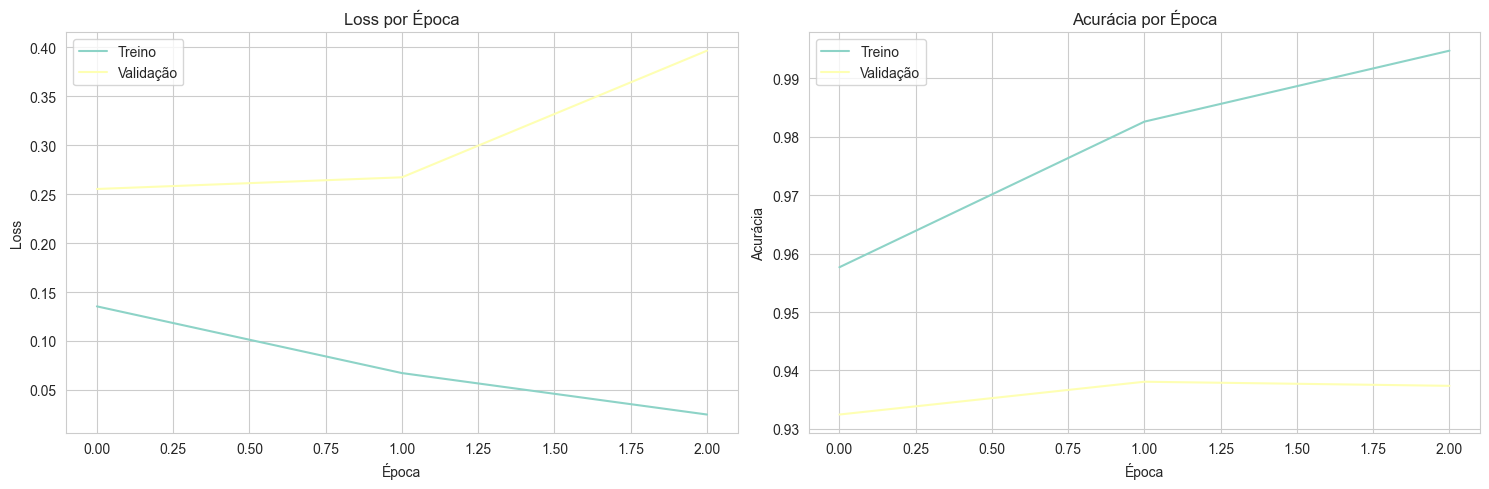

In [17]:
# Visualizar curvas de aprendizado
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history['train_loss'], label='Treino')
axes[0].plot(history['val_loss'], label='Validação')
axes[0].set_title('Loss por Época')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# Acurácia
axes[1].plot(history['train_acc'], label='Treino')
axes[1].plot(history['val_acc'], label='Validação')
axes[1].set_title('Acurácia por Época')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('Acurácia')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## 9. Avaliação no Conjunto de Teste

Avaliando o modelo treinado no conjunto de teste com métricas detalhadas.

In [18]:
# Função para obter predições
def get_predictions(model, data_loader, device):
    """
    Obtém todas as predições e labels
    """
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Predizendo'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

# Obter predições no conjunto de teste
y_pred, y_true = get_predictions(model, test_loader, device)

# Calcular métricas
test_accuracy = accuracy_score(y_true, y_pred)
print(f"\nAcurácia no conjunto de teste: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\n" + "="*50 + "\n")

# Relatório de classificação
print("Relatório de Classificação:")
print(classification_report(y_true, y_pred, target_names=['Negativo (0)', 'Positivo (1)']))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
print("\nMatriz de Confusão:")
print(cm)


Acurácia no conjunto de teste: 0.9404 (94.04%)


Relatório de Classificação:
              precision    recall  f1-score   support

Negativo (0)       0.93      0.95      0.94      2850
Positivo (1)       0.95      0.93      0.94      2850

    accuracy                           0.94      5700
   macro avg       0.94      0.94      0.94      5700
weighted avg       0.94      0.94      0.94      5700


Matriz de Confusão:
[[2712  138]
 [ 202 2648]]


In [19]:
# Visualização da Matriz de Confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negativo (0)', 'Positivo (1)'],
            yticklabels=['Negativo (0)', 'Positivo (1)'])
plt.title('Matriz de Confusão - BERT')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predito')
plt.tight_layout()
plt.show()

# Métricas detalhadas
tn, fp, fn, tp = cm.ravel()
print(f"\nVerdadeiros Negativos: {tn}")
print(f"Falsos Positivos: {fp}")
print(f"Falsos Negativos: {fn}")
print(f"Verdadeiros Positivos: {tp}")
print(f"\nTaxa de Falso Positivo: {fp/(fp+tn):.4f}")
print(f"Taxa de Falso Negativo: {fn/(fn+tp):.4f}")


Verdadeiros Negativos: 2712
Falsos Positivos: 138
Falsos Negativos: 202
Verdadeiros Positivos: 2648

Taxa de Falso Positivo: 0.0484
Taxa de Falso Negativo: 0.0709


## 10. Teste com Novos Textos

Testando o modelo BERT com exemplos customizados.

In [20]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    """
    Prediz o sentimento de um texto usando o modelo BERT
    """
    model.eval()
    
    # Tokenizar (usando API moderna)
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    # Predizer
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.argmax(logits, dim=1).item()
    
    sentiment = "Positivo" if prediction == 1 else "Negativo"
    return sentiment, prediction

# Testar com exemplos novos
test_reviews = [
    "This place is amazing! Best food I've ever had. Highly recommend!",
    "Terrible service, cold food, and overpriced. Never coming back.",
    "It was okay, nothing special but not bad either.",
    "Absolutely loved it! The staff was friendly and the atmosphere was great.",
    "Worst experience ever. Waited for an hour and the food was disgusting."
]

print("Predições do BERT para Novos Textos:")
print("="*70)
for i, review in enumerate(test_reviews, 1):
    sentiment, label = predict_sentiment(review, model, tokenizer, device)
    print(f"\n{i}. Texto: {review}")
    print(f"   Sentimento: {sentiment} (label={label})")


1. Texto: This place is amazing! Best food I've ever had. Highly recommend!
   Sentimento: Positivo (label=1)

2. Texto: Terrible service, cold food, and overpriced. Never coming back.
   Sentimento: Negativo (label=0)

3. Texto: It was okay, nothing special but not bad either.
   Sentimento: Negativo (label=0)

4. Texto: Absolutely loved it! The staff was friendly and the atmosphere was great.
   Sentimento: Positivo (label=1)

5. Texto: Worst experience ever. Waited for an hour and the food was disgusting.
   Sentimento: Negativo (label=0)


## 11. Comparação Final: BERT vs SVM (BoW e Embeddings)

Comparando as três abordagens implementadas neste projeto.

In [21]:
# Tabela comparativa das três abordagens
comparison_data = {
    'Aspecto': [
        'Representação',
        'Dimensionalidade',
        'Pré-treinamento',
        'Contexto',
        'Arquitetura',
        'Parâmetros Treináveis',
        'Tempo de Treinamento',
        'Complexidade',
        'Hardware Necessário',
        'Interpretabilidade',
        'Estado da Arte'
    ],
    'SVM + BoW': [
        'Vetores esparsos',
        'Alta (5000+)',
        'Não',
        'Nenhum',
        'SVM (linear)',
        '~5000',
        'Minutos',
        'Baixa',
        'CPU suficiente',
        'Alta',
        'Baseline (2000s)'
    ],
    'SVM + Embeddings': [
        'Vetores densos',
        'Média (100-300)',
        'Sim (Word2Vec)',
        'Janela local',
        'SVM (RBF)',
        '~100k (Word2Vec)',
        '< 1 hora',
        'Média',
        'CPU suficiente',
        'Média',
        'Estado da arte (2013-2017)'
    ],
    'BERT': [
        'Embeddings contextuais',
        'Alta (768)',
        'Sim (massivo)',
        'Bidirecional completo',
        'Transformers (12 camadas)',
        '~110M',
        'Horas (GPU recomendada)',
        'Alta',
        'GPU recomendada',
        'Baixa',
        'Estado da arte (2018+)'
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("Comparação das Três Abordagens:")
print("="*100)
print(comparison_df.to_string(index=False))
print("\n" + "="*100)

Comparação das Três Abordagens:
              Aspecto        SVM + BoW           SVM + Embeddings                      BERT
        Representação Vetores esparsos             Vetores densos    Embeddings contextuais
     Dimensionalidade     Alta (5000+)            Média (100-300)                Alta (768)
      Pré-treinamento              Não             Sim (Word2Vec)             Sim (massivo)
             Contexto           Nenhum               Janela local     Bidirecional completo
          Arquitetura     SVM (linear)                  SVM (RBF) Transformers (12 camadas)
Parâmetros Treináveis            ~5000           ~100k (Word2Vec)                     ~110M
 Tempo de Treinamento          Minutos                   < 1 hora   Horas (GPU recomendada)
         Complexidade            Baixa                      Média                      Alta
  Hardware Necessário   CPU suficiente             CPU suficiente           GPU recomendada
   Interpretabilidade             Alta          

## 12. Conclusões

### Resumo do Modelo BERT
- **Arquitetura**: BERT base (12 camadas Transformer, 110M parâmetros)
- **Fine-tuning**: 3 épocas com learning rate 2e-5
- **Dataset**: Avaliações do Yelp com classificação binária
- **Tokenização**: WordPiece com max_length=128

### Vantagens do BERT
1. **Compreensão contextual profunda**: Captura nuances de linguagem que BoW e Word2Vec não conseguem
2. **Embeddings contextuais**: Cada palavra tem representação diferente dependendo do contexto
3. **Bidirecional**: Analisa o texto completo em ambas as direções
4. **Transfer learning**: Aproveita conhecimento de bilhões de palavras pré-treinadas
5. **Estado da arte**: Melhor performance em múltiplas tarefas de NLP
6. **Polissemia**: Trata palavras com múltiplos significados corretamente

### Desvantagens do BERT
1. **Custo computacional**: Requer GPU para treinamento eficiente
2. **Tempo de treinamento**: Muito mais lento que SVM
3. **Complexidade**: Mais difícil de debugar e entender
4. **Tamanho do modelo**: 110M parâmetros (~400MB)
5. **Latência**: Inferência mais lenta que modelos tradicionais
6. **Overfitting**: Pode overfit em datasets pequenos

### Quando usar cada abordagem?

**Use SVM + BoW quando:**
- Dataset é grande e vocabulário é rico
- Recursos computacionais são muito limitados
- Velocidade é crítica (produção em larga escala)
- Interpretabilidade é essencial
- Baseline rápido é necessário

**Use SVM + Embeddings quando:**
- Quer melhor performance que BoW sem complexidade do BERT
- Dataset tem palavras raras ou vocabulário limitado
- Recursos computacionais são limitados (apenas CPU)
- Precisa de bom equilíbrio entre performance e custo

**Use BERT quando:**
- Performance é prioridade máxima
- Dataset tem nuances linguísticas complexas
- Tem acesso a GPU para treinamento
- Pode tolerar latência maior na inferência
- Dataset é suficientemente grande (>1000 exemplos por classe)

### Evolução Histórica
1. **2000s**: BoW + modelos clássicos (SVM, Naive Bayes)
2. **2013**: Word2Vec revoluciona embeddings estáticos
3. **2018**: BERT introduz embeddings contextuais
4. **Futuro**: Modelos maiores (GPT, LLaMA) e mais eficientes

### Próximos Passos
1. Experimentar com outros modelos: RoBERTa, DistilBERT, ALBERT
2. Aumentação de dados para melhorar generalização
3. Ensemble de múltiplos modelos
4. Análise de atenção para interpretar decisões do BERT
5. Quantização e destilação para produção eficiente